In [42]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import vizlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import lasagne
import nolearn.lasagne
from lasagne.layers import *
import theano
import theano.tensor as T
from sklearn.metrics import confusion_matrix
import nolearn.lasagne.visualize

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (12.0, 8.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


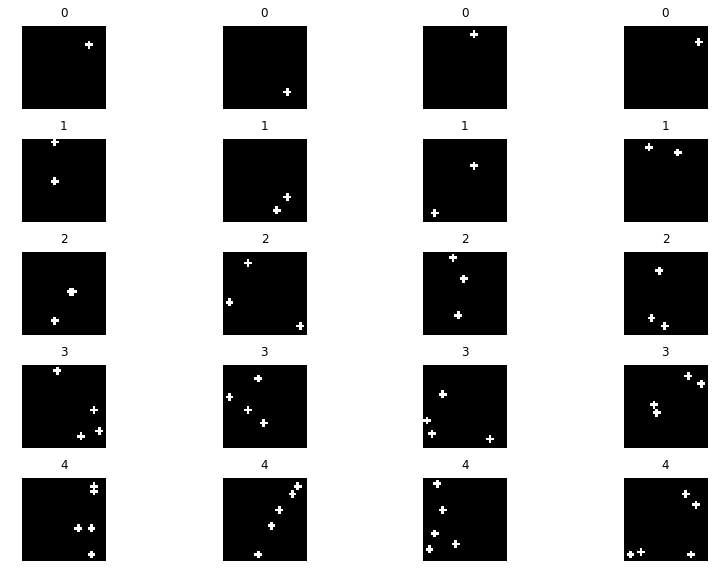

In [44]:
ds = vizlib.data.counting_2d(size=(32,32), n_examples=10000, min_spots=1, max_spots=5, seed=42).show_sample()
plt.tight_layout()
# Plot is a bit misleading --- all spots are the same shape.

In [45]:
ds.X.shape, ds.y.max()

((10000, 1, 32, 32), 4)

In [60]:
il = InputLayer((None,1,32,32))
cl = Conv2DLayer(il, num_filters=1, filter_size=(3,3), pad='same')
dl = DenseLayer(cl, num_units=5, nonlinearity=lasagne.nonlinearities.softmax)

In [61]:
nn = nolearn.lasagne.NeuralNet(dl, verbose=1, update_learning_rate=1e-2, update_momentum=0.9)

In [62]:
nn.fit(ds.X, ds.y)

# Neural Network with 5135 learnable parameters

## Layer information

  #    name  output_shapes    nonlinearity    conv_shapes
---  ------  ---------------  --------------  -------------
  0          1x32x32
             1x32x32          rectify         3x3|P=sxaxmxe
             5                softmax

  epoch    train loss    valid loss    train/val    train acc    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----------  -----
      1       1.44471       1.21282      1.19120      0.33983      0.39882  1.30s
      2       1.09123       1.00132      1.08979      0.43136      0.52426  1.28s
      3       0.94835       0.89637      1.05799      0.58154      0.61266  1.27s
      4       0.85794       0.81701      1.05009      0.65793      0.62883  1.28s
      5       0.78405       0.74694      1.04969      0.72010      0.77939  1.28s
      6       0.72104       0.69290      1.04062      0.78156      0.81006  1.28s
      7       0.66866       0.64535  

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f739d902bd0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f739d902b50>,
     custom_score=None,
     layers=[<lasagne.layers.dense.DenseLayer object at 0x7f7382bfc450>],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x7f739d909de8>,
     objective_loss_function=<function categorical_crossentropy at 0x7f739e52a0c8>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f7382159b90>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7f7380440cb0>],
     regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit object at 0x7f739d902c10>,
     update=<function nesterov_momentum at 0x7f739e52a9b0>,
     update_learning_rate=0.01, update_momentum=0.9,
     use_label_encoder=False, verbose=1,
     y_tens

In [63]:
confusion_matrix(ds.y, nn.predict(ds.X)), (ds.y == nn.predict(ds.X)).mean()
# We always predict 1s as 2s.
# But other than that we never predict more spots than there actually are.

(array([[   0, 1896,    0,    0,    0],
        [   0, 2009,    0,    0,    0],
        [   0,   45, 2007,    0,    0],
        [   0,    0,    2, 2003,    0],
        [   0,    0,    0,    5, 2033]]), 0.80520000000000003)

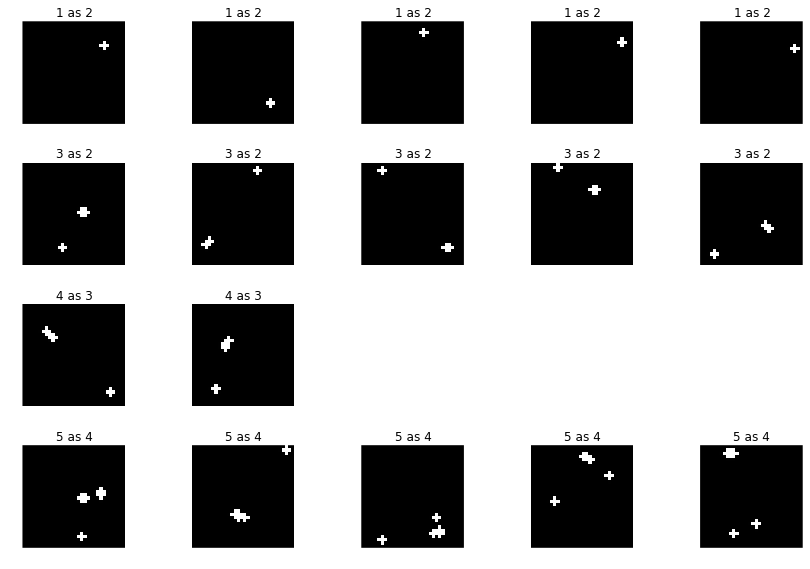

In [64]:
y = nn.predict(ds.X)
incorrect = ds.y != y

# there are quite a few 3s classified as 2s.
# we just want to look at some incorrect samples, not all of them.
plot_idx = 1
for c in (1, 3, 4, 5):
    incorrect_for_c = incorrect & (ds.y == c - 1)
    yact = ds.y[incorrect_for_c]
    ypre = y[incorrect_for_c]
    xs = ds.X[incorrect_for_c]
    
    for i in range(min(5, len(xs))):
        plt.subplot(4, 5, plot_idx + i)
        plt.title('{} as {}'.format(yact[i] + 1, ypre[i] + 1))
        plt.imshow(xs[i].squeeze())
        plt.axis('off')
    plot_idx += 5
plt.tight_layout()

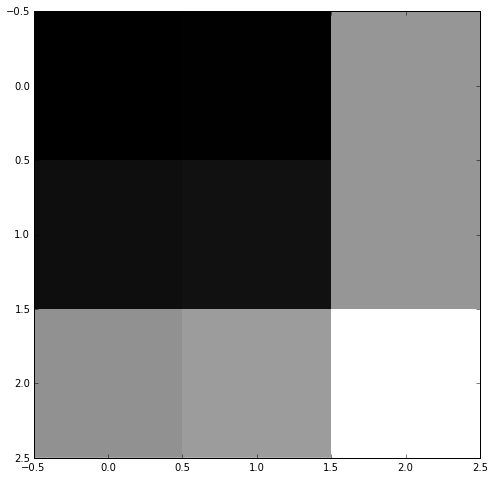

In [177]:
# Let's look naively at the network weights
# The flipping is needed since we are using convolutions, not correlations.
plt.imshow(cl.W.get_value().squeeze()[::-1,::-1])
# This filter is already much different from what I would expect (a cross)

In [178]:
cl.W.get_value().squeeze()[::-1,::-1]

array([[-3.3575, -3.3523, -1.6121],
       [-3.1934, -3.1523, -1.6046],
       [-1.6716, -1.544 , -0.3821]], dtype=float32)

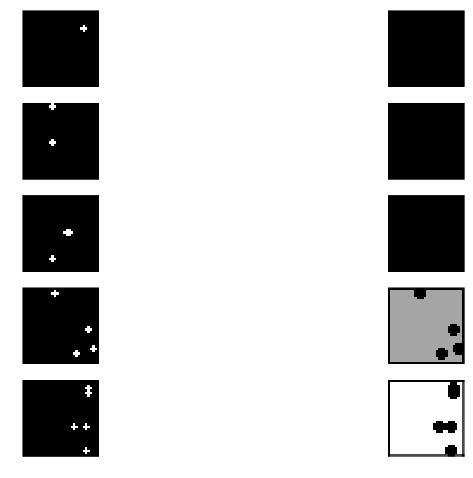

In [189]:
# Alternatively instead of looking at the filter, we can look at the outputs of the filter applied to input images.
f = theano.function([il.input_var], lasagne.layers.get_output(cl))
cs = (1,2,3,4,5)
xs = np.array([ds.X[ds.y == (c - 1)][0] for c in cs])
ys = f(xs)
vmin, vmax = ys.min(), ys.max()

for i, c in enumerate(cs, 0):
    x, y = xs[i], ys[i]
    plt.subplot(5, 2, i * 2 + 1)
    plt.imshow(x.squeeze())
    plt.axis('off')    
    plt.subplot(5, 2, i * 2 + 2)
    plt.imshow(y.squeeze(), vmax=vmax, vmin=vmin)
    plt.axis('off')


In [190]:
# The filter is strongly negative, the dataset is standardized per *image*,
# This means that images w/ more spots will have stronger negative values in their non-spot areas,
# such that the mean can still become 0.
(xs[-1][:, :3, :3] * cl.W.get_value().squeeze()[::-1,::-1],
 xs[0][:, :3, :3] * cl.W.get_value().squeeze()[::-1,::-1])

(array([[[ 0.5201,  0.5193,  0.2497],
         [ 0.4947,  0.4884,  0.2486],
         [ 0.259 ,  0.2392,  0.0592]]], dtype=float32),
 array([[[ 0.2352,  0.2348,  0.1129],
         [ 0.2237,  0.2208,  0.1124],
         [ 0.1171,  0.1082,  0.0268]]], dtype=float32))

In [192]:
# The conv layer is using a rectifier.
# coupling this w/ a relatively strong negative bias, 
# implies that the output will be all 0s for most input w/ only 1 or 2 spots.
cl.b.get_value()

array([-2.2926], dtype=float32)

In [199]:
# The question then is why did the image w/ three spots not activate?
# Probably because this is one of the misclassified images:
nn.predict(xs[2:3]) # => which it is

array([1])

In [201]:
# Try another 3 that is not misclassified:
three = ds.X[ds.y == (3 - 1)][1]
nn.predict(three[None,:,:,:]) # => 2 is correct, classes are offset by 1

array([2])

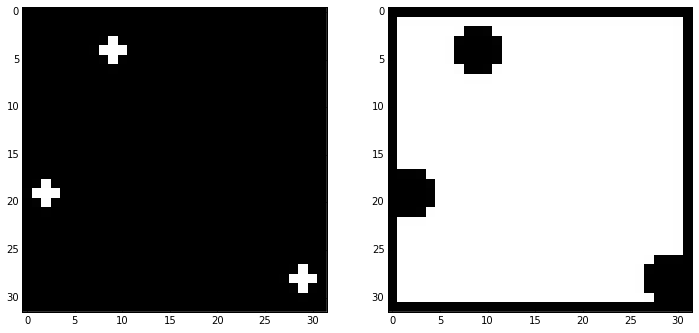

In [203]:
plt.subplot(1,2,1)
plt.imshow(three.squeeze())
plt.subplot(1,2,2)
plt.imshow(f(three[None,:,:,:]).squeeze())

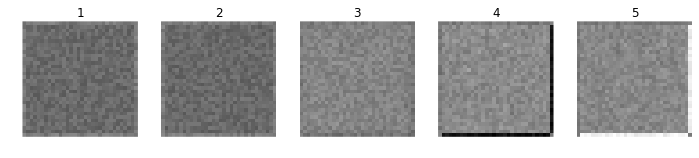

In [74]:
W = dl.W.get_value().reshape(32, 32, 5)
vmin, vmax = W.min(), W.max()
for i in range(1, 5+1):
    plt.subplot(1, 5, i)
    plt.title(i)
    plt.imshow(W[:,:,i-1], vmax=vmax, vmin=vmin)
    plt.axis('off')
# The filters do not seem all that different,
# other than the behavior at the borders for class 4 and 5.

In [79]:
dl.b.get_value()

array([ 4.6534,  4.728 ,  1.5799, -5.4344, -5.527 ], dtype=float32)

In [85]:
# It is no surprise that with the bias of class 1 < class 2,
# and their filters not significantly different,
# that class 1 is often mistaken for class 2.
# Let's see if we can fix this:
b_old = dl.b.get_value()
b_new = b_old.copy()
b_new[0] = 4.7285
dl.b.set_value(b_new)

In [86]:
confusion_matrix(ds.y, nn.predict(ds.X)), (ds.y == nn.predict(ds.X)).mean()
# now all 2s are 1s, and some 3s are 1s!

(array([[1896,    0,    0,    0,    0],
        [2009,    0,    0,    0,    0],
        [  45,    0, 2007,    0,    0],
        [   0,    0,    2, 2003,    0],
        [   0,    0,    0,    5, 2033]]), 0.79390000000000005)

In [131]:
b_new = b_old.copy()
b_new[0] = 4.728015185
dl.b.set_value(b_new)
confusion_matrix(ds.y, nn.predict(ds.X)), (ds.y == nn.predict(ds.X)).mean()
# Could not find a cutoff point where some 2s become 2s while some 1s stay 1s.

(array([[1896,    0,    0,    0,    0],
        [2009,    0,    0,    0,    0],
        [  45,    0, 2007,    0,    0],
        [   0,    0,    2, 2003,    0],
        [   0,    0,    0,    5, 2033]]), 0.79390000000000005)

In [132]:
dl.b.set_value(b_old)

In [142]:
# Interpreting the network using just these simple weights is already too difficult [for me].
# Let's look at some visualization techniques.
X_init = np.random.randn(1, 1, 32, 32).astype(theano.config.floatX)
X_init -= X_init.mean()
X_init /= X_init.std()
max_norm = lasagne.utils.compute_norms(X_init).max()

scores_and_maximizers = vizlib.activation_maximization.maximize_scores(
    dl, X_init, number_of_iterations=100, max_norm=max_norm,
)
scores, maximizers = zip(*scores_and_maximizers)

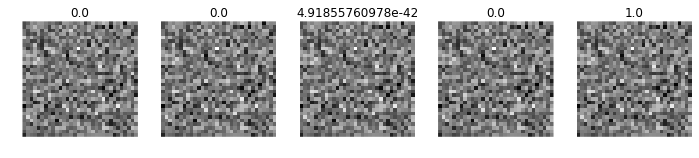

In [150]:
vmax = max(m.max() for s, m in scores_and_maximizers)
vmin = min(m.min() for s, m in scores_and_maximizers)
for i, (s, m) in enumerate(scores_and_maximizers, 1):
    plt.subplot(1, len(scores_and_maximizers), i)
    plt.imshow(m.squeeze(), vmax=vmax, vmin=vmin)
    plt.axis('off')
    plt.title(s)
# Not sure how to interpret this!

In [152]:
# Lets look at the probabilities assigned to these so called maximizers.
for s, m in scores_and_maximizers:
    print(nn.predict_proba(m))

[[ 0.  0.  0.  0.  1.]]
[[ 0.  0.  0.  0.  1.]]
[[ 0.  0.  0.  0.  1.]]
[[ 0.  0.  0.  0.  1.]]
[[ 0.  0.  0.  0.  1.]]


INFO (theano.gof.compilelock): Refreshing lock /home/jan/.theano/compiledir_Linux-3.16--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/jan/.theano/compiledir_Linux-3.16--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/lock_dir/lock


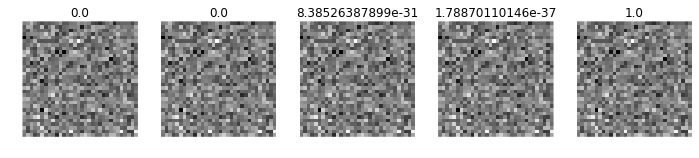

In [147]:
# Repeat the same experiment, but this time maximize the
# softmax output, rather than the activation.
X_init = np.random.randn(1, 1, 32, 32).astype(theano.config.floatX)
X_init -= X_init.mean()
X_init /= X_init.std()
max_norm = lasagne.utils.compute_norms(X_init).max()

scores_and_maximizers = vizlib.activation_maximization.maximize_scores(
    dl, X_init, number_of_iterations=100, max_norm=max_norm,
    ignore_nonlinearity=False,
)
scores, maximizers = zip(*scores_and_maximizers)

vmax = max(m.max() for s, m in scores_and_maximizers)
vmin = min(m.min() for s, m in scores_and_maximizers)
for i, (s, m) in enumerate(scores_and_maximizers, 1):
    plt.subplot(1, len(scores_and_maximizers), i)
    plt.imshow(m.squeeze(), vmax=vmax, vmin=vmin)
    plt.axis('off')
    plt.title(s)

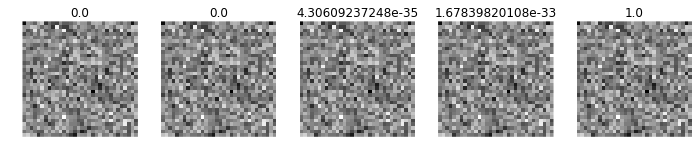

In [153]:
# Repeat the same experiment, but this time maximize the
# softmax output, rather than the activation.
X_init = np.random.randn(1, 1, 32, 32).astype(theano.config.floatX)
X_init -= X_init.mean()
X_init /= X_init.std()
max_norm = lasagne.utils.compute_norms(X_init).max()

scores_and_maximizers = vizlib.activation_maximization.maximize_scores(
    dl, X_init, number_of_iterations=100, max_norm=None,
    ignore_nonlinearity=False,
)
scores, maximizers = zip(*scores_and_maximizers)

vmax = max(m.max() for s, m in scores_and_maximizers)
vmin = min(m.min() for s, m in scores_and_maximizers)
for i, (s, m) in enumerate(scores_and_maximizers, 1):
    plt.subplot(1, len(scores_and_maximizers), i)
    plt.imshow(m.squeeze(), vmax=vmax, vmin=vmin)
    plt.axis('off')
    plt.title(s)

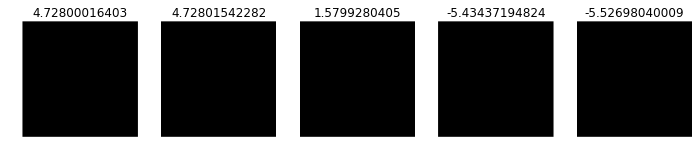

In [158]:
# This initialization might lean
# too much toward the class w/ the most spot
# Repeat the experiment, but this time start from all 0s.
X_init = np.zeros((1, 1, 32, 32)).astype(theano.config.floatX)

scores_and_maximizers = vizlib.activation_maximization.maximize_scores(
    dl, X_init, number_of_iterations=100, max_norm=None,
    ignore_nonlinearity=True,
)
scores, maximizers = zip(*scores_and_maximizers)

vmax = max(m.max() for s, m in scores_and_maximizers)
vmin = min(m.min() for s, m in scores_and_maximizers)
for i, (s, m) in enumerate(scores_and_maximizers, 1):
    plt.subplot(1, len(scores_and_maximizers), i)
    plt.imshow(m.squeeze(), vmax=vmax, vmin=vmin)
    plt.axis('off')
    plt.title(s)
# Which does not escape the local minima of all 0s.

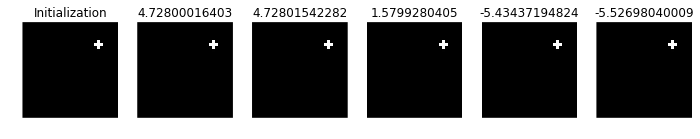

In [162]:
# Start instead from an initialization that is related to the
# training set.
X_init = ds.X[0:1]

scores_and_maximizers = vizlib.activation_maximization.maximize_scores(
    dl, X_init, number_of_iterations=100, max_norm=None,
    ignore_nonlinearity=True,
)
scores, maximizers = zip(*scores_and_maximizers)

vmax = max(m.max() for s, m in scores_and_maximizers)
vmin = min(m.min() for s, m in scores_and_maximizers)
plt.subplot(1, len(scores_and_maximizers) + 1, 1)
plt.imshow(X_init.squeeze())
plt.title('Initialization')
plt.axis('off')
for i, (s, m) in enumerate(scores_and_maximizers, 2):
    plt.subplot(1, len(scores_and_maximizers) + 1, i)
    plt.imshow(m.squeeze(), vmax=vmax, vmin=vmin)
    plt.axis('off')
    plt.title(s)

In [ ]:
# Not sure how to interpret all the results here,
# and if the guarantee correctness.
# Nevertheless, it seems more fruitfull to try to train a new network.
# One that possibly uses some pooling, so that we get better results.